In [107]:
import pandas as pd
import numpy as np
from scipy import stats as stats
from scipy import interpolate
import sklearn
from matplotlib import pyplot as plt
import regex
import datetime
import pickle

In [108]:
#%matplotlib inline
#plt.ioff()
#plt.ion()

In [109]:
#df=pd.read_csv('kc_house_data_train.csv')
df=pd.read_csv('data/kc_house_data.csv')

In [110]:
df.shape

(21597, 21)

In [111]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

Let's do an initial data exploration

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [113]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


We can begin by setting the ID as the proper index.

In [114]:
df=df.set_index(['id'])

Note that the date column is full of string objects.  From our initial look at the dataframe, it appears each entry is a particular pattern.  First, confirm this

In [115]:
###IGNORE
#date_patt='([0-9]{4})([0-9]{2})([0-9]{2})T'
#rgx=regex.compile(date_patt)
#confirm=df.date.apply(lambda x:bool(rgx.match(x)))
##extract the data using this pattern.
#df[['sale_yr','sale_month','day']]=df.date.str.extract(date_patt)
#df[['sale_yr','sale_month','day']]=df[['sale_yr','sale_month','day']].applymap(int)
#df.date=df.apply(lambda r:datetime.datetime(r.sale_yr,r.sale_month,r.day),axis=1)

In [116]:
df.date=df.date.apply(lambda d:pd.to_datetime(d))

It will be helpful to split this data up by year and by quarter.

In [117]:
df['sale_yr']=df.date.apply(lambda d:d.year)
df['sale_month']=df.date.apply(lambda d:d.month)

In [118]:
#We note that all the sales occured in 2014 or 2015.  (We may later set this to a categorical variable.)
df.sale_yr.value_counts()

2014    14622
2015     6975
Name: sale_yr, dtype: int64

In [119]:
#Now we want to add a factor for each quarter/season.  (We will later set this to a categorical variable as well.)
quart_dict={
            1:'Winter',
            2:'Winter',
            3:'Spring',
            4:'Spring',
            5:'Spring',
            6:'Summer',
            7:'Summer',
            8:'Summer',
            9:'Fall',
            10:'Fall',
            11:'Fall',
            12:'Winter'
            }
df['season']=df.sale_month.map(quart_dict)
df['season'].value_counts()

Spring    6518
Summer    6328
Fall      5056
Winter    3695
Name: season, dtype: int64

We note that the prices are all at least $1k.  So for readability, lets divide by 1,000.  (This changes the datatype of this variable from int to float.)

Check for duplicates

In [120]:
df.index.duplicated().sum()

177

Interesting...Let's see what these entries look like.

In [121]:
df[df.index.duplicated()]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sale_yr,sale_month,season
id,,,,,,,,,,,,,,,,,,,,,
6021501535,2014-12-23,700000.0,3,1.50,1580,5000,1.0,0.0,0.0,3,...,1939,0.0,98117,47.6870,-122.386,1570,4500,2014,12,Winter
4139480200,2014-12-09,1400000.0,4,3.25,4290,12103,1.0,0.0,3.0,3,...,1997,0.0,98006,47.5503,-122.102,3860,11244,2014,12,Winter
7520000520,2015-03-11,240500.0,2,1.00,1240,12092,1.0,0.0,0.0,3,...,1922,1984.0,98146,47.4957,-122.352,1820,7460,2015,3,Spring
3969300030,2014-12-29,239900.0,4,1.00,1000,7134,1.0,0.0,0.0,3,...,1943,NaN,98178,47.4897,-122.240,1020,7138,2014,12,Winter
2231500030,2015-03-24,530000.0,4,2.25,2180,10754,1.0,0.0,0.0,5,...,1954,0.0,98133,47.7711,-122.341,1810,6929,2015,3,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7853400250,2015-02-19,645000.0,4,3.50,2910,5260,2.0,0.0,0.0,3,...,2012,0.0,98065,47.5168,-121.883,2910,5260,2015,2,Winter
2724049222,2014-12-01,220000.0,2,2.50,1000,1092,2.0,0.0,0.0,3,...,2004,0.0,98118,47.5419,-122.271,1330,1466,2014,12,Winter
8564860270,2015-03-30,502000.0,4,2.50,2680,5539,2.0,NaN,0.0,3,...,2013,0.0,98045,47.4759,-121.734,2680,5992,2015,3,Spring


In [122]:
df.duplicated().sum()

0

So there are duplicates by index but no entries are entire duplicates.  Let's look at specific example.

In [123]:
df.loc[7853420110]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sale_yr,sale_month,season
id,,,,,,,,,,,,,,,,,,,,,
7853420110,2014-10-03,594866.0,3,3.0,2780,6000,2.0,0.0,0.0,3,...,2013,0.0,98065,47.5184,-121.886,2850,6000,2014,10,Fall
7853420110,2015-05-04,625000.0,3,3.0,2780,6000,2.0,0.0,0.0,3,...,2013,NaN,98065,47.5184,-121.886,2850,6000,2015,5,Spring


It would appear that our dataset includes multiple sales of the same house!  (Might be worth looking at....)

In [124]:
#Try To Distinguish by adding year of sale to the id...
df2=df.reset_index()
df2.apply(lambda r:str(r.id)+str(r.sale_yr),axis=1).duplicated().sum()

42

Need to be more specific...

In [125]:
df2=df.reset_index()
df2.apply(lambda r:str(r.id)+str(r.sale_yr)+str(r.sale_month),axis=1).duplicated().sum()

0

So we will adjust our dataframe's index to include_year & month.

In [126]:
df2=df.reset_index()
df2['id']=df2.apply(lambda r:str(r.id)+str(r.sale_yr)[-2:]+str(r.sale_month),axis=1)
df=df2.set_index(['id'])

We need to check if there are any NA values.

In [127]:
df.isna().sum()

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
sale_yr             0
sale_month          0
season              0
dtype: int64

We notice that there are three columns which have missing values.  For waterfront and year renovated, we will assume that missing values represent negative answers (i.e., no waterfront view and no renovations) so we replace this missing values w/ '0'.  However, no such intuition exists for view count and since only 63 (of 21.5k) observations do not have a value for missing, we will simply drop these values.

In [128]:
df.waterfront=df.waterfront.fillna(0)
df.yr_renovated=df.yr_renovated.fillna(0)
df=df.dropna(subset=['view'])

In [129]:
df.shape

(21534, 23)

In [130]:
df.isna().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
sale_yr          0
sale_month       0
season           0
dtype: int64

For later programming conveniuence, and as a part of the initial data exploration, we wish to organize the dataset by our target variable and different types of factors (numerical, categorical, and other).  We further divided the numerical factors into two types: dense & sparse.  The latter include factors which have limited # of different values.  Such variables, like # of bedrooms, will be modeled as continous variables but purposes of data exploration, etc. should be treated as categorical.  We also need to divide the categorical variables into binary and ordinal.  This distinction will be important in the regression stage as categorical variables will eventually be split into dummies.

For the most parts, the factors proper designation was self-evident.  However, the variables yr_built and yr_renovated are both a bit murkier.  Let's dive a bit deeper into these two variables.

In [131]:
#What years were these houses built and how many houses were built in each year?
yrs=df.yr_built.value_counts().sort_index()
yrs

1900     87
1901     29
1902     27
1903     46
1904     45
       ... 
2011    130
2012    170
2013    200
2014    558
2015     38
Name: yr_built, Length: 116, dtype: int64

In [132]:
yrs.nsmallest(10)

1934    21
1935    24
1902    27
1901    29
1933    30
1932    38
2015    38
1936    40
1904    45
1903    46
Name: yr_built, dtype: int64

<AxesSubplot:>

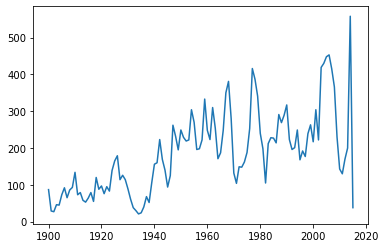

In [133]:
fig,ax=plt.subplots()
yrs.plot(ax=ax)

The dataset appears to be fairly robust wrt yr_built so it probably makes sense to treat it as a continous factor.  At this point, it is also worth noting that we should adjust this data to be relative to the year of sale.   We are interested in how old the house was at time of sale not the year it was built.

It may later be of interest to create a categorical variable that captures what year (or years) a house was built

In [134]:
df['age']=df.sale_yr-df.yr_built
df.age.value_counts()

 9      470
 8      443
 0      429
 11     428
 10     428
       ... 
 113     28
 115     26
 81      23
 80      21
-1       12
Name: age, Length: 117, dtype: int64

Odd that we have 12 observations that, it would appear, were sold before they were built.  Let's look at these observations:

In [135]:
df.loc[df.age==-1][['date','sale_yr','yr_built']]

,date,sale_yr,yr_built
id,,,
1832100030146,2014-06-25,2014,2015
30765008301410,2014-10-29,2014,2015
95209002101412,2014-12-31,2014,2015
1250200495146,2014-06-24,2014,2015
2770601530148,2014-08-26,2014,2015
9126100346146,2014-06-17,2014,2015
9126100765148,2014-08-01,2014,2015
9310300160148,2014-08-28,2014,2015
1257201420147,2014-07-09,2014,2015


It would in fact appear that these observations have a year of sale that occurs prior to the year built.  Is this an error or is there a qualitative explanation (e.g. our dataset could include purchases of empty lots and/or incomplete homes.)  How should we handle these observations?

In [136]:
#For now, just set them equal to zero
df.age=df.age.replace(-1,0)
df.age.value_counts().sort_index()

0      441
1      284
2      174
3      165
4      117
      ... 
111     50
112     33
113     28
114     69
115     26
Name: age, Length: 116, dtype: int64

In [137]:
#What years were these houses renovated and how many houses were built in each year?
yrs=df.yr_renovated.value_counts().sort_index()
yrs

0.0       20791
1934.0        1
1940.0        2
1944.0        1
1945.0        3
          ...  
2011.0        9
2012.0        8
2013.0       31
2014.0       73
2015.0       14
Name: yr_renovated, Length: 70, dtype: int64

In [138]:
yrs.nsmallest(10)

1934.0    1
1944.0    1
1946.0    1
1948.0    1
1950.0    1
1951.0    1
1953.0    1
1954.0    1
1959.0    1
1971.0    1
Name: yr_renovated, dtype: int64

<AxesSubplot:>

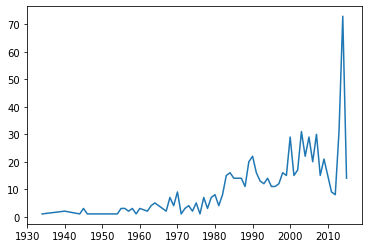

In [139]:
#For purposes of graphing this data, we need to drop the observations that were never renovated.
fig,ax=plt.subplots()
yrs.drop([0]).plot(ax=ax)

This variable is not as clear-cut.  For the years between 1930 and 2015, we have at least one observation that was renovated in that year.  But the data is heavily, heaviliy weighted in more recent years.  We also have to account for houses which were sold before ever being renovated.  Therefore, it may make more sense to actually categorize this data, after again adjusting for when the sale occured.

In [140]:
df['last_renovation']=df.apply(lambda r:r.sale_yr-r.yr_renovated if r.yr_renovated>0 else -1,axis=1)

In [141]:
#Building a function to categorize as follows:
####No Renovation
####Renovation 25+years prior sale (prior to 1989 for 2014 sales and 1990 for 2015 sales)
####Renovation 10-24 years prior to sale (1990-2004 for 2014 sales & 1991-2005 for 2015 sales)
####Renovation 5-9 years prior to sale (2005-2009 for 2014 sales & 2006-2010 for 2015 sales)
####Renovation 2-4 years prior to sale (2010-2012 for 2014 sales & 2011-2013 for 2015 sales)
####Renovation within a year of the sale (2013 & 2014 for 2014 sales & 2014 & 2015 for 2015 sales)
def renovation_status(obs):
    s=''
    x=obs.last_renovation
    if(x==-1):
        s='Never'
    elif(x>24):
        s='25+'
    elif(x>9):
        s='10-24'
    elif(x>4):
        s='5-9'
    elif(x>1):
        s='2-4'
    elif(x==1 or x==0):
        s='Recent'
    return s

df['renovation_status']=df.apply(renovation_status,axis=1)

In [142]:
df.renovation_status.value_counts()

Never     20797
10-24       260
25+         229
5-9         108
Recent      105
2-4          35
Name: renovation_status, dtype: int64

...Odd:  only 105 "Recent"s and more (6) "Never"s than expected.  Is there something wrong with the data?  Let's explore:

In [143]:
#Is there an issue with the calculation between year of sale and year of renovation?
df.last_renovation.value_counts().sort_index()

-1.0     20797
 0.0        68
 1.0        37
 2.0        13
 3.0         9
         ...  
 66.0        1
 69.0        3
 70.0        2
 74.0        2
 80.0        1
Name: last_renovation, Length: 70, dtype: int64

In [144]:
#From the values with -1, it would appear so.  Let's see what those data entries look like:
df.loc[(df.last_renovation==-1)&(df.yr_renovated!=0)][['date','yr_renovated','sale_yr']]

,date,yr_renovated,sale_yr
id,,,
8712100320147,2014-07-28,2015.0,2014
91411000051410,2014-10-28,2015.0,2014
7284900030145,2014-05-22,2015.0,2014
3585900665146,2014-06-06,2015.0,2014
35859001901410,2014-10-06,2015.0,2014
8935100100147,2014-07-01,2015.0,2014


Renovations that occured AFTER the sale....Similar issue to what we saw with year built.  Is there a qualitative explanation?  What should be done with the observations? Either way, we will need to adjust how df.last_rennovation flags observations w/ no renovations.  It is also probably worthwhile to make it a constant variable and have our function use it as well:

In [145]:
NO_RENO=-100
df['last_renovation']=df.apply(lambda r:r.sale_yr-r.yr_renovated if r.yr_renovated>0 else NO_RENO,axis=1)
def renovation_status(obs):
    s=''
    x=obs.last_renovation
    if(x==NO_RENO):
        s='Never'
    elif(x>24):
        s='25+'
    elif(x>9):
        s='10-24'
    elif(x>4):
        s='5-9'
    elif(x>1):
        s='2-4'
    elif(x==1 or x==0 or x==-1):
        s='Recent'
    return s

df['renovation_status']=df.apply(renovation_status,axis=1)
df.renovation_status.value_counts()

Never     20791
10-24       260
25+         229
Recent      111
5-9         108
2-4          35
Name: renovation_status, dtype: int64

Next, we want to figure out the square footage factors which will likely overlap with eachother (multicollinearity...).
First, let's deal with sqft living and sqft lot--the latter obviously includes the former so it is duplicative information.  However, we can calculate the square footage of the outside area ("the yard"):

In [146]:
df['sqft_outside']=df['sqft_lot']-df['sqft_living']
df['sqft_outside15']=df['sqft_lot15']-df['sqft_living15']

Next, the square footage of above and basement are obviously included in the square footage of living (sqft_living = sqft_above + sqft_basement). To isolate these variables, let's look at a ration--percentage above.

In [147]:
df['percent_above']=df.sqft_above/df.sqft_living

What do the grade and condition factors look like?  Should they be treated as a sparse continuous factor, an ordinal factor or a categorical factor?

In [148]:
df.grade.value_counts()

7     8948
8     6053
9     2604
6     2031
10    1130
11     397
5      242
12      88
4       27
13      13
3        1
Name: grade, dtype: int64

In [149]:
df.condition.value_counts()

3    13981
4     5657
5     1697
2      170
1       29
Name: condition, dtype: int64

It appears that for both, we can treat the data as ordinal (there is a clear ordering between each category).

We can finally organize this data as desired.

In [150]:
#splitting up the dataframe between target and factors, further organized by type.
target=['price']
dense_factors=['sqft_living','sqft_outside','percent_above','sqft_living15','sqft_outside15','age']
sparse_factors=['bedrooms','bathrooms','floors','view','grade','condition']
ordinal_factors=['renovation_status']
category_factors=['season','waterfront']
other=['zipcode','lat','long','month','day','sale_yr']

In [151]:
#Lets set the category_factors to datatype category....
df.sale_yr=df.sale_yr.astype('category')
df.waterfront=df.waterfront.astype('category')
df.condition=df.condition.astype('category')
df.season=df.season.astype('category')

In [152]:
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'sale_yr', 'sale_month', 'season', 'age',
       'last_renovation', 'renovation_status', 'sqft_outside',
       'sqft_outside15', 'percent_above'],
      dtype='object')

Outlier Analysis

In [153]:
#Want to look at variables which are not categorical.
df_quant=df[target+dense_factors+sparse_factors]

In [154]:
#Calculate Z_Scores for all the quantitative columns.
df_zScores=df_quant.apply(stats.zscore)
df_zScores.head()

,price,sqft_living,sqft_outside,percent_above,sqft_living15,sqft_outside15,age,bedrooms,bathrooms,floors,view,grade,condition
id,,,,,,,,,,,,,
71293005201410,-0.869162,-0.980819,-0.207151,0.728030,-0.943359,-0.237857,0.533731,-0.402680,-1.451646,-0.915398,-0.305436,-0.560649,-0.629726
64141001921412,-0.005621,0.534291,-0.202251,-0.182470,-0.432488,-0.177461,0.669894,-0.402680,0.174721,0.937163,-0.305436,-0.560649,-0.629726
5631500400152,-0.983627,-1.427722,-0.091700,0.728030,1.070931,-0.199828,1.316669,-1.482141,-1.451646,-0.915398,-0.305436,-1.413443,-0.629726
24872008751412,0.174681,-0.130613,-0.241834,-1.988023,-0.914166,-0.262547,0.193323,0.676781,1.150541,-0.915398,-0.305436,-0.560649,2.444177
1954400510152,-0.082113,-0.435815,-0.160340,0.728030,-0.271929,-0.186526,-0.521533,-0.402680,-0.150553,-0.915398,-0.305436,0.292146,-0.629726


In [155]:
#Define an extreme threshold.  Z-Scores above this threshold will be flagged.
threshold=10
out_bool=df_zScores.apply(lambda x:abs(x)>threshold)
out_bool['totals']=out_bool.apply(sum,axis=1)
out_bool.sum()

price             10
sqft_living        2
sqft_outside      35
percent_above      0
sqft_living15      0
sqft_outside15    28
age                0
bedrooms           1
bathrooms          0
floors             0
view               0
grade              0
condition          0
totals            76
dtype: int64

In [156]:
out_bool.totals.value_counts().sort_index()

0    21467
1       58
2        9
Name: totals, dtype: int64

In [157]:
#We can choose to drop all observations which have 1 or two extreme values.
outliers=out_bool.totals.nlargest(67)
df_clean=df.drop(outliers.index.values,axis=0)
df_clean.shape

(21467, 29)

In [159]:
variable_types={
    'target':target,
    'dense':dense_factors,
    'sparse':sparse_factors,
    'categorical':category_factors,
    'ordinal':ordinal_factors,
    'other':other
}
with open('variable_org','wb') as f:
    pickle.dump(variable_types,f)
df_clean.to_pickle('Clean_Train.pkl')